In [1]:
# Создаём спарк контекст
from pyspark.sql import SparkSession
from pyspark.ml.functions import vector_to_array
import pyspark.sql.functions as F

from pyspark.ml.feature import HashingTF, IDF, Tokenizer, Word2Vec
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.classification import FMClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MultilabelClassificationEvaluator


import pandas as pd
import tqdm


spark = SparkSession.builder\
        .master('local[40]')\
        .appName('HW5')\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

sc = spark.sparkContext

22/12/11 02:32:39 WARN Utils: Your hostname, user-ubuntu-pc resolves to a loopback address: 127.0.1.1; using 192.168.1.7 instead (on interface wlo1)
22/12/11 02:32:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/11 02:32:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


tfidf

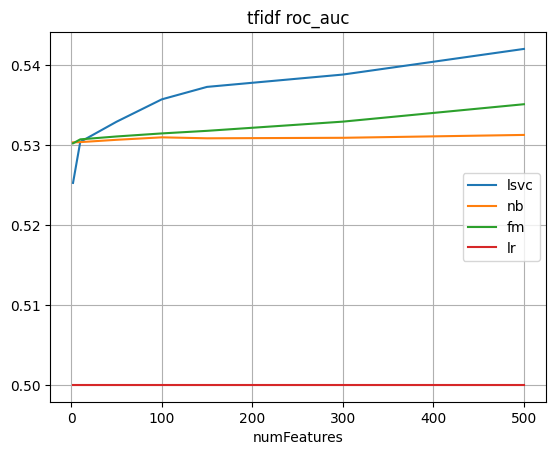

w2v

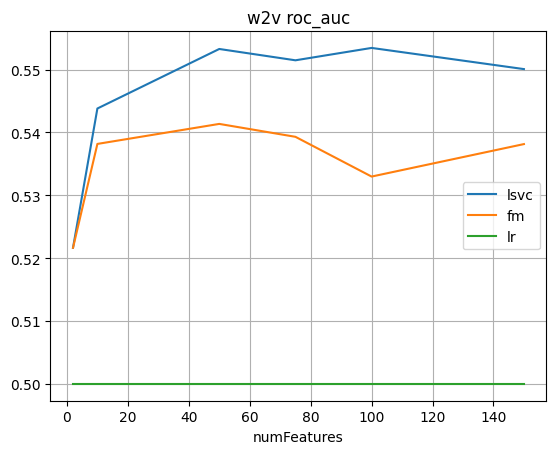

Загружаем данные:

In [2]:
train = spark.read.csv('jigsaw-toxic-comment-classification-challenge/train.csv', sep=',', quote='\"', escape='\"', multiLine=True, header=True, inferSchema=True)
test = spark.read.csv('jigsaw-toxic-comment-classification-challenge/test.csv', sep=',', quote='\"', escape='\"', multiLine=True, header=True, inferSchema=True)
test_labels = spark.read.csv('jigsaw-toxic-comment-classification-challenge/test_labels.csv', sep=',', quote='\"', escape='\"', multiLine=True, header=True, inferSchema=True)

In [3]:
target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate',]
num_features = [2, 10, 50, 75, 100, 150, 300, 500]

test = test.join(test_labels.select('id', *[(F.col(col) * -1).alias(col) for col in target_cols]), 'id')

Рассчитываем скоры tfidf:

In [5]:
tokenizer = Tokenizer(inputCol="comment_text", outputCol="words")

train_tokenized = tokenizer.transform(train).cache()
test_tokenized = tokenizer.transform(test).cache()

nums_scores = []
for numFeatures in tqdm.tqdm(num_features):
    

    hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="tf", numFeatures=numFeatures)
    idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")

    tf_idf_pipe = Pipeline(stages=[hashingTF, idf])
    tf_idf_pipe = tf_idf_pipe.fit(train_tokenized)
    train_tfidf = tf_idf_pipe.transform(train_tokenized)
    test_tfidf = tf_idf_pipe.transform(test_tokenized)

    for model in tqdm.tqdm(['lsvc', 'nb', 'fm', 'lr',]):
        model_stages = []
        for target_name in target_cols:
            if model == 'lr':
                model_stages.append(
                    LogisticRegression(
                        featuresCol=idf.getOutputCol(), 
                        labelCol=target_name, 
                        probabilityCol=f'{target_name}__probabilityCol', 
                        rawPredictionCol=f'{target_name}__rawPredictionCol',  
                        predictionCol=f'{target_name}__predictionCol', 
                        maxIter=10, 
                        regParam=0.3, 
                        elasticNetParam=0.8)
                )
            elif model == 'lsvc':
                model_stages.append(
                    LinearSVC(
                        featuresCol=idf.getOutputCol(), 
                        labelCol=target_name, 
                        rawPredictionCol=f'{target_name}__rawPredictionCol',  
                        predictionCol=f'{target_name}__predictionCol', 
                        maxIter=10, 
                        regParam=0.1)
                )
            elif model == 'nb':
                model_stages.append(
                    NaiveBayes(
                        featuresCol=idf.getOutputCol(), 
                        labelCol=target_name, 
                        probabilityCol=f'{target_name}__probabilityCol', 
                        rawPredictionCol=f'{target_name}__rawPredictionCol',  
                        predictionCol=f'{target_name}__predictionCol', 
                        smoothing=1.0, 
                        modelType="multinomial")
                )
            elif model == 'fm':
                model_stages.append(
                    FMClassifier(
                        featuresCol=idf.getOutputCol(), 
                        labelCol=target_name, 
                        probabilityCol=f'{target_name}__probabilityCol', 
                        rawPredictionCol=f'{target_name}__rawPredictionCol', 
                        predictionCol=f'{target_name}__predictionCol', 
                        stepSize=0.001)
                )

        model_pipe = Pipeline(stages=model_stages)
        models_transformer = model_pipe.fit(train_tfidf)
        results = models_transformer.transform(test_tfidf)\
            .select(*target_cols, *[f'{x}__rawPredictionCol' for x in target_cols]).cache()
        scores = []
        for target_name in target_cols:

            metrics = BinaryClassificationEvaluator(
                labelCol=target_name, 
                rawPredictionCol=f'{target_name}__rawPredictionCol'
            )
            scores.append(metrics.evaluate(results))
        results.unpersist()
        nums_scores.append((numFeatures, model, sum(scores) / len(target_cols)))

train_tokenized.unpersist()
test_tokenized.unpersist()

22/12/11 00:38:18 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 


22/12/11 00:38:45 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 


22/12/11 00:39:04 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 


                                                                                
                                                                                
                                                                                
                                                                                
100%|██████████| 4/4 [04:05<00:00, 61.37s/it]
                                                                                


22/12/11 00:43:15 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 


                                                                                
                                                                                
                                                                                
                                                                                
100%|██████████| 4/4 [06:04<00:00, 91.08s/it] 
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
100%|██████████| 4/4 [10:53<00:00, 163.47s/it]
                                                                                
                                                                                
               

22/12/11 01:07:26 WARN BlockManager: Asked to remove block broadcast_8656, which does not exist


                                                                                
                                                                                
100%|██████████| 4/4 [13:07<00:00, 196.81s/it]
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
100%|██████████| 4/4 [14:32<00:00, 218.00s/it]
                                                                                


22/12/11 01:27:32 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/12/11 01:27:32 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


                                                                                
                                                                                
                                                                                
                                                                                
100%|██████████| 4/4 [16:10<00:00, 242.56s/it]
                                                                                
                                                                                
                                                                                


22/12/11 01:48:21 WARN BlockManager: Asked to remove block broadcast_13891, which does not exist


22/12/11 01:58:27 WARN BlockManager: Asked to remove block broadcast_14837, which does not exist


                                                                                
                                                                                
100%|██████████| 7/7 [1:22:34<00:00, 707.78s/it]


DataFrame[id: string, comment_text: string, toxic: int, severe_toxic: int, obscene: int, threat: int, insult: int, identity_hate: int, words: array<string>]

Сторим график:

Text(0.5, 1.0, 'tfidf roc_auc')

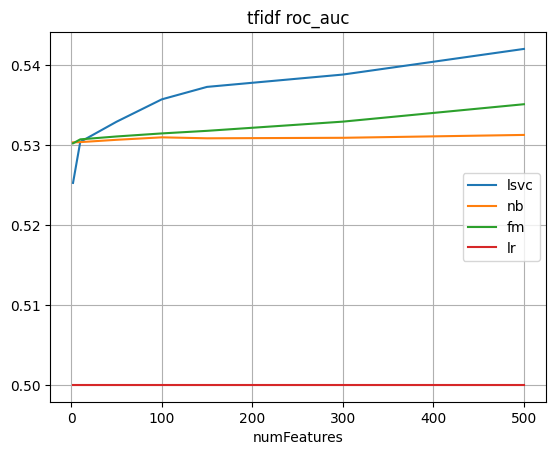

In [6]:
results = pd.DataFrame(nums_scores, columns=['numFeatures', 'linear_model', 'roc_auc'])

model = 'lsvc'
ax = results[results['linear_model'] == model]\
    .set_index('numFeatures')\
    .rename(columns={'roc_auc': model})\
    .plot(grid=True, label=model)

for model in ['nb', 'fm', 'lr',]: 
    results[results['linear_model'] == model]\
    .set_index('numFeatures')\
    .rename(columns={'roc_auc': model})\
    .plot(grid=True, label=model, ax=ax)
ax.set_title('tfidf roc_auc')

Рассчитываем скоры w2v:

In [4]:
tokenizer = Tokenizer(inputCol="comment_text", outputCol="words")

train_tokenized = tokenizer.transform(train).cache()
test_tokenized = tokenizer.transform(test).cache()

nums_scores_2 = []
for numFeatures in tqdm.tqdm(num_features):

    idf = Word2Vec(inputCol=tokenizer.getOutputCol(), outputCol="tf", vectorSize=numFeatures)

    tf_idf_pipe = Pipeline(stages=[idf])
    tf_idf_pipe = tf_idf_pipe.fit(train_tokenized)
    train_tfidf = tf_idf_pipe.transform(train_tokenized)
    test_tfidf = tf_idf_pipe.transform(test_tokenized)

    for model in tqdm.tqdm(['lsvc', 'fm', 'lr',]):
        model_stages = []
        for target_name in target_cols:
            if model == 'lr':
                model_stages.append(
                    LogisticRegression(
                        featuresCol=idf.getOutputCol(), 
                        labelCol=target_name, 
                        probabilityCol=f'{target_name}__probabilityCol', 
                        rawPredictionCol=f'{target_name}__rawPredictionCol', 
                        predictionCol=f'{target_name}__predictionCol', 
                        maxIter=10, 
                        regParam=0.3, 
                        elasticNetParam=0.8)
                )
            elif model == 'lsvc':
                model_stages.append(
                    LinearSVC(
                        featuresCol=idf.getOutputCol(), 
                        labelCol=target_name, 
                        rawPredictionCol=f'{target_name}__rawPredictionCol',  
                        predictionCol=f'{target_name}__predictionCol', 
                        maxIter=10, 
                        regParam=0.1)
                )
            elif model == 'fm':
                model_stages.append(
                    FMClassifier(
                        featuresCol=idf.getOutputCol(), 
                        labelCol=target_name, 
                        probabilityCol=f'{target_name}__probabilityCol', 
                        rawPredictionCol=f'{target_name}__rawPredictionCol', 
                        predictionCol=f'{target_name}__predictionCol', 
                        stepSize=0.001)
                )

        model_pipe = Pipeline(stages=model_stages)
        models_transformer = model_pipe.fit(train_tfidf)
        results = models_transformer.transform(test_tfidf).select(*target_cols, *[f'{x}__rawPredictionCol' for x in target_cols]).cache()
        
        scores = []
        for target_name in target_cols:

            metrics = BinaryClassificationEvaluator(labelCol=target_name, rawPredictionCol=f'{target_name}__rawPredictionCol')
            scores.append(metrics.evaluate(results))

        results.unpersist()
        nums_scores_2.append((numFeatures, model, sum(scores) / len(target_cols)))

train_tokenized.unpersist()
test_tokenized.unpersist()

                                                                                
                                                                                
                                                                                
                                                                                
100%|██████████| 3/3 [02:58<00:00, 59.48s/it]
                                                                                
                                                                                


22/12/11 02:42:23 WARN BlockManager: Asked to remove block broadcast_2614, which does not exist


                                                                                
                                                                                
100%|██████████| 3/3 [06:50<00:00, 136.83s/it]
                                                                                
                                                                                


22/12/11 02:55:14 WARN BlockManager: Asked to remove block broadcast_4224, which does not exist


                                                                                
                                                                                
100%|██████████| 3/3 [24:49<00:00, 496.56s/it]
                                                                                
                                                                                
                                                                                
                                                                                
100%|██████████| 3/3 [36:01<00:00, 720.61s/it] 
                                                                                
                                                                                
                                                                                
                                                                                
100%|██████████| 3/3 [47:25<00:00, 948.61s/it] 
                                               

22/12/11 04:43:31 WARN MemoryStore: Not enough space to cache rdd_11969_0 in memory! (computed 177.0 MiB so far)
22/12/11 04:43:31 WARN BlockManager: Persisting block rdd_11969_0 to disk instead.


22/12/11 04:43:39 WARN MemoryStore: Not enough space to cache rdd_12026_0 in memory! (computed 177.0 MiB so far)
22/12/11 04:43:39 WARN BlockManager: Persisting block rdd_12026_0 to disk instead.


22/12/11 04:43:47 WARN MemoryStore: Not enough space to cache rdd_12086_0 in memory! (computed 177.0 MiB so far)
22/12/11 04:43:47 WARN BlockManager: Persisting block rdd_12086_0 to disk instead.


22/12/11 04:43:53 WARN MemoryStore: Not enough space to cache rdd_12143_0 in memory! (computed 177.0 MiB so far)
22/12/11 04:43:53 WARN BlockManager: Persisting block rdd_12143_0 to disk instead.


22/12/11 04:44:01 WARN MemoryStore: Not enough space to cache rdd_12203_0 in memory! (computed 177.0 MiB so far)
22/12/11 04:44:01 WARN BlockManager: Persisting block rdd_12203_0 to disk instead.


22/12/11 04:44:09 WARN MemoryStore: Not enough space to cache rdd_12261_0 in memory! (computed 177.0 MiB so far)
22/12/11 04:44:09 WARN BlockManager: Persisting block rdd_12261_0 to disk instead.


22/12/11 04:44:21 WARN MemoryStore: Not enough space to cache rdd_12440_0 in memory! (computed 151.7 MiB so far)
22/12/11 04:44:21 WARN BlockManager: Persisting block rdd_12440_0 to disk instead.


22/12/11 04:55:41 WARN MemoryStore: Not enough space to cache rdd_12675_0 in memory! (computed 151.7 MiB so far)
22/12/11 04:55:41 WARN BlockManager: Persisting block rdd_12675_0 to disk instead.


22/12/11 05:06:59 WARN MemoryStore: Not enough space to cache rdd_12910_0 in memory! (computed 151.7 MiB so far)
22/12/11 05:06:59 WARN BlockManager: Persisting block rdd_12910_0 to disk instead.


22/12/11 05:18:15 WARN MemoryStore: Not enough space to cache rdd_13145_0 in memory! (computed 151.7 MiB so far)
22/12/11 05:18:15 WARN BlockManager: Persisting block rdd_13145_0 to disk instead.


22/12/11 05:29:40 WARN MemoryStore: Not enough space to cache rdd_13380_0 in memory! (computed 151.7 MiB so far)
22/12/11 05:29:40 WARN BlockManager: Persisting block rdd_13380_0 to disk instead.


22/12/11 05:40:59 WARN MemoryStore: Not enough space to cache rdd_13615_0 in memory! (computed 151.7 MiB so far)
22/12/11 05:40:59 WARN BlockManager: Persisting block rdd_13615_0 to disk instead.


22/12/11 05:52:48 WARN MemoryStore: Not enough space to cache rdd_13972_0 in memory! (computed 177.0 MiB so far)
22/12/11 05:52:48 WARN BlockManager: Persisting block rdd_13972_0 to disk instead.


22/12/11 05:52:54 WARN MemoryStore: Not enough space to cache rdd_14008_0 in memory! (computed 177.0 MiB so far)
22/12/11 05:52:54 WARN BlockManager: Persisting block rdd_14008_0 to disk instead.


22/12/11 05:53:01 WARN MemoryStore: Not enough space to cache rdd_14044_0 in memory! (computed 177.0 MiB so far)
22/12/11 05:53:01 WARN BlockManager: Persisting block rdd_14044_0 to disk instead.


22/12/11 05:53:07 WARN MemoryStore: Not enough space to cache rdd_14080_0 in memory! (computed 177.0 MiB so far)
22/12/11 05:53:07 WARN BlockManager: Persisting block rdd_14080_0 to disk instead.


22/12/11 05:53:13 WARN MemoryStore: Not enough space to cache rdd_14116_0 in memory! (computed 177.0 MiB so far)
22/12/11 05:53:13 WARN BlockManager: Persisting block rdd_14116_0 to disk instead.


22/12/11 05:53:20 WARN MemoryStore: Not enough space to cache rdd_14152_0 in memory! (computed 177.0 MiB so far)
22/12/11 05:53:20 WARN BlockManager: Persisting block rdd_14152_0 to disk instead.


                                                                                
 75%|███████▌  | 6/8 [3:20:44<1:06:54, 2007.46s/it]                 (0 + 1) / 1]


22/12/11 05:53:31 ERROR Executor: Exception in task 0.0 in stage 5787.0 (TID 5355)
java.lang.OutOfMemoryError: Java heap space
	at com.esotericsoftware.kryo.io.Input.readFloats(Input.java:861)
	at com.esotericsoftware.kryo.serializers.DefaultArraySerializers$FloatArraySerializer.read(DefaultArraySerializers.java:109)
	at com.esotericsoftware.kryo.serializers.DefaultArraySerializers$FloatArraySerializer.read(DefaultArraySerializers.java:92)
	at com.esotericsoftware.kryo.Kryo.readClassAndObject(Kryo.java:813)
	at org.apache.spark.serializer.KryoDeserializationStream.readObject(KryoSerializer.scala:306)
	at org.apache.spark.serializer.DeserializationStream$$anon$1.getNext(Serializer.scala:168)
	at org.apache.spark.util.NextIterator.hasNext(NextIterator.scala:73)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.maybeCacheDisk

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/user/.cache/pypoetry/virtualenvs/hadoop-mapreduce-fsUWYKvG-py3.10/lib/python3.10/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/user/.cache/pypoetry/virtualenvs/hadoop-mapreduce-fsUWYKvG-py3.10/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/user/.cache/pypoetry/virtualenvs/hadoop-mapreduce-fsUWYKvG-py3.10/lib/python3.10/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
ERROR:root:Exception while sending command.
Traceback (most recent call last

ConnectionRefusedError: [Errno 111] Connection refused

Text(0.5, 1.0, 'w2v roc_auc')

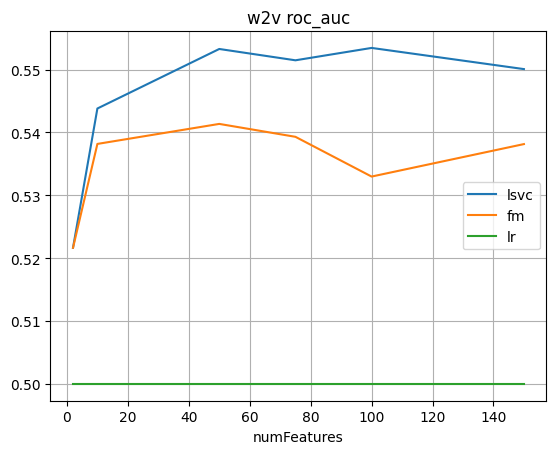

In [5]:
results = pd.DataFrame(nums_scores_2, columns=['numFeatures', 'linear_model', 'roc_auc'])

model = 'lsvc'
ax = results[results['linear_model'] == model]\
    .set_index('numFeatures')\
    .rename(columns={'roc_auc': model})\
    .plot(grid=True, label=model)

for model in ['fm', 'lr',]: 
    results[results['linear_model'] == model]\
    .set_index('numFeatures')\
    .rename(columns={'roc_auc': model})\
    .plot(grid=True, label=model, ax=ax)
ax.set_title('w2v roc_auc')